In [3]:
source("../../code/utils.r")
library(zoo)
library(dplyr)
library(lubridate)
load("../../raw-rda/arecanut-sirsi-3varieties.rda")

# notebook settings
options(repr.plot.width=10, repr.plot.height=4)


# generate train and validation sets --------------------------------------
basedf <- antSBCR %>% filter(variety %in% "bilegotu")
valseq <- as.numeric(tail(row.names(basedf),4))
traindf <- basedf[-valseq,]
valdf <- basedf[valseq,]
rm(valseq);

In [7]:
y <- ts(traindf$modal,start=c(year(traindf$yearmon[1]),month(traindf$yearmon[1])),frequency = 12)
yval <- ts(valdf$modal,start=c(year(valdf$yearmon[1]),month(valdf$yearmon[1])),frequency = 12)


standata <- within(list(), {
  y <- as.vector(y)
  n <- length(y)
  npred <-3
})

## Actual series

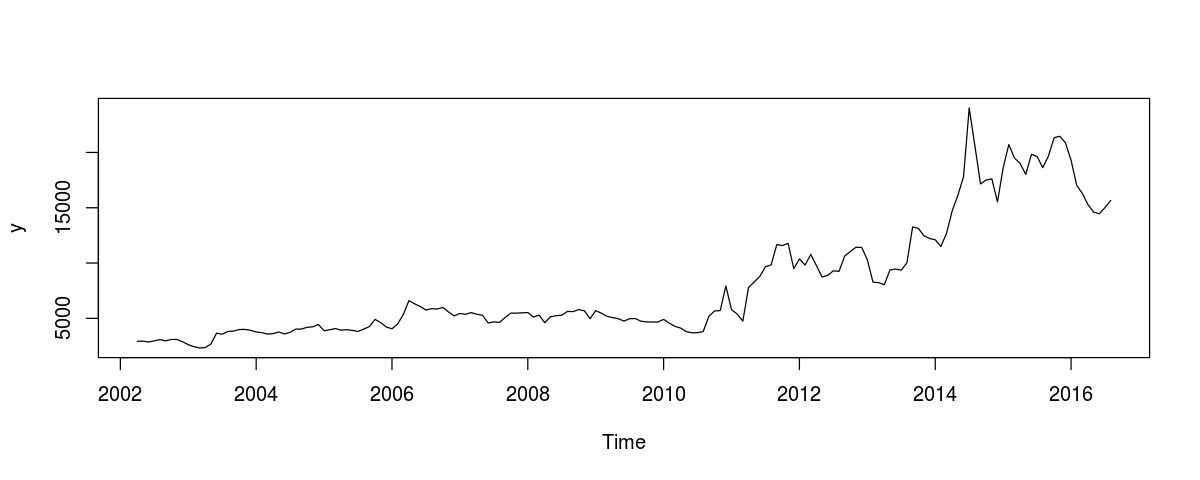

In [101]:
plot(y,type="l")

## Random walk plus noise
  $$log(y) \sim N(\mu[t], \sigma_{irreg})$$
  
  $$\mu[t] \sim N(\mu[t-1], \sigma_{level})$$

In [5]:
# model_file1 <- '../../code/04-stan-models-02/model01.stan'
# fit1 <- invisible(stan(file = model_file1, data = standata,
#                             warmup = 10000, iter = 20000, chains = 1))
# save(file="code/04-stan-models-02/rda/fit1.rda",fit1)

In [131]:
load(file="rda/fit1.rda")
stopifnot(is.converged(fit1))

## Predicted and actual comparison

Don't know how to automatically pick scale for object of type yearmon. Defaulting to continuous.


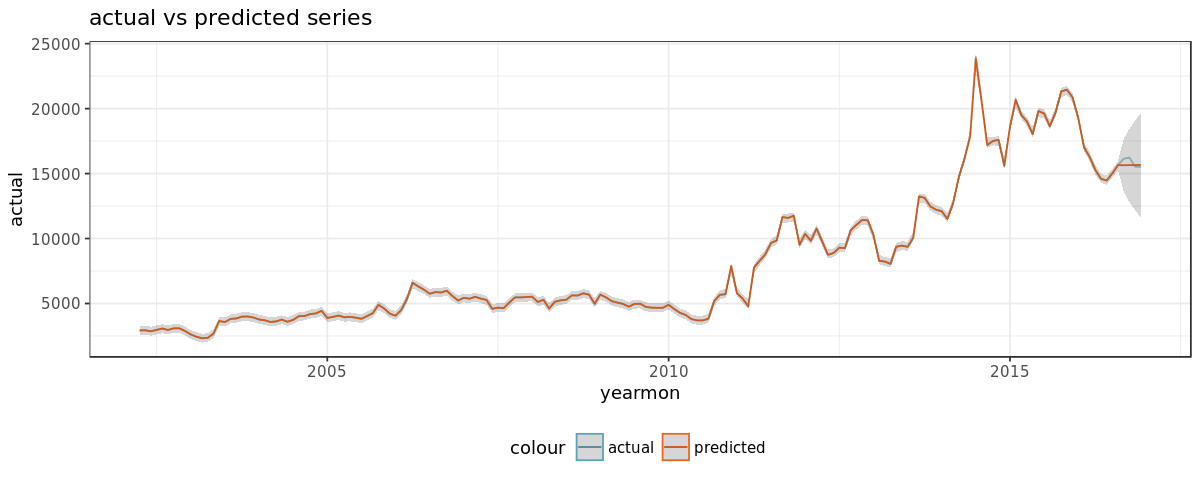

In [132]:
fit_ss1 <- extract(fit1 , permuted = TRUE)

plotPrediction <- function(trainvec,valvec,fitss){
    trainquants <- t(as.matrix(apply(fitss$yhat, 2, quantile, probs = c(.025, .5, .975))))
    valquants <- t(as.matrix(apply(fitss$ypred, 2, quantile, probs = c(.025, .5, .975))))
    plotdf <- data.frame(actual = c(trainvec,valvec),yearmon = c(as.yearmon(time(y)),as.yearmon(time(yval))))
    plotdf <- cbind(plotdf,rbind(trainquants,valquants))

    q <- ggplot(plotdf, aes(x = yearmon, y = actual, colour = "actual")) + 
                  geom_line(alpha=0.6) +
                  geom_line(aes(y=`50%`,colour="predicted",), data = plotdf) +
                  geom_ribbon(aes(ymax = `97.5%`, ymin = `2.5%`, colour = NULL), data = plotdf, alpha = 0.2) +
                  scale_color_manual(values=c("actual"="#58a4b0", "predicted"="#f26419")) +
                  theme(legend.position="bottom") +
                  ggtitle("actual vs predicted series")
    print(q)
}
plotPrediction(y,yval,fit_ss1)


Last 4 points were predicted using random walk model, and it can be seen that the actual values are well within the prediction interval, but the interval itself is very wide. Also, taking the closer look at the prediction below, we can see the model fails to capture the variation across 4 points.

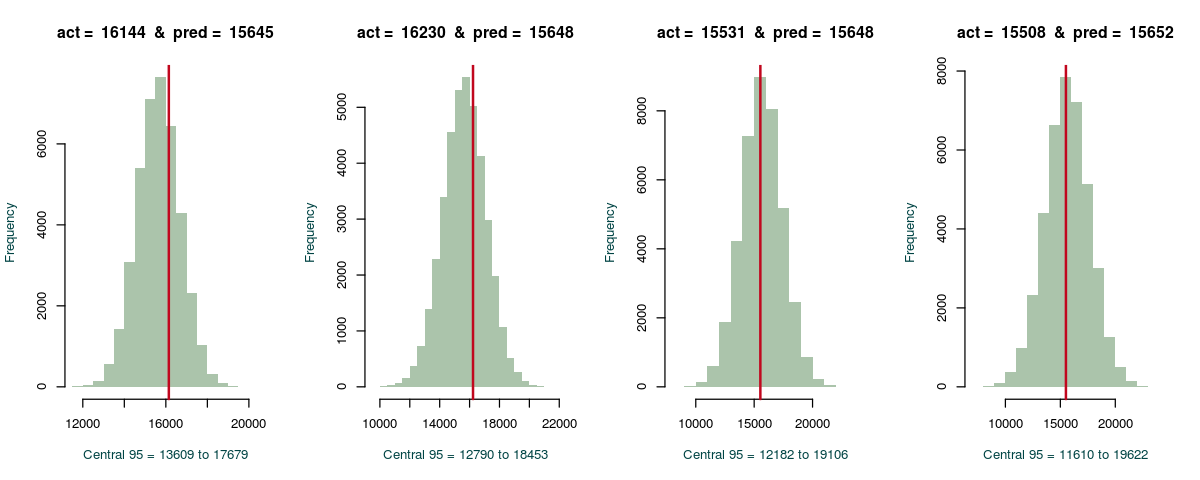

In [158]:
valpred <- as.data.frame(fit_ss1$ypred)
colnames(valpred) <- paste(as.yearmon(time(yval)))

valplots <- list()

par(mfrow=c(1,ncol(valpred)))
for (i in 1:ncol(valpred)){
    hist(valpred[,i],
         xlab = paste("Central 95 =",paste(round(quantile(valpred[,i],c(0.025,0.975))),collapse=" to ")),
         main= paste("act = ",round(yval[i])," & ","pred = ",round(mean(valpred[,i]))),col="#abc4ab",lty=0.2,
         col.lab = "#004444")
    abline(v=yval[i],col="#c1071e",lwd = 2)
}

## Posterior distributions

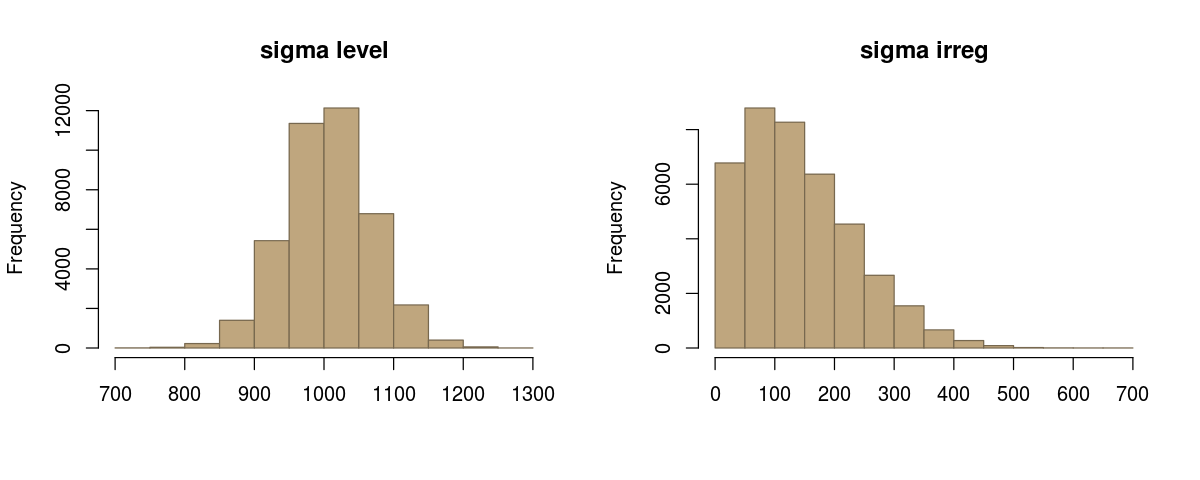

In [134]:
par(mfrow=c(1,2))
hist(fit_ss1$sigma_level,main="sigma level",xlab = NULL,col="#bfa67e", border = "#77684f")
hist(fit_ss1$sigma_irreg,main="sigma irreg",xlab = NULL,col="#bfa67e", border = "#77684f")


It can be seen that the sigma level paramter is very wide with mean value of around 1000, this could lead to the wide prediction interval. (Also, isnt sigma irreg supposed to be centered around zero?)

## Residual plots

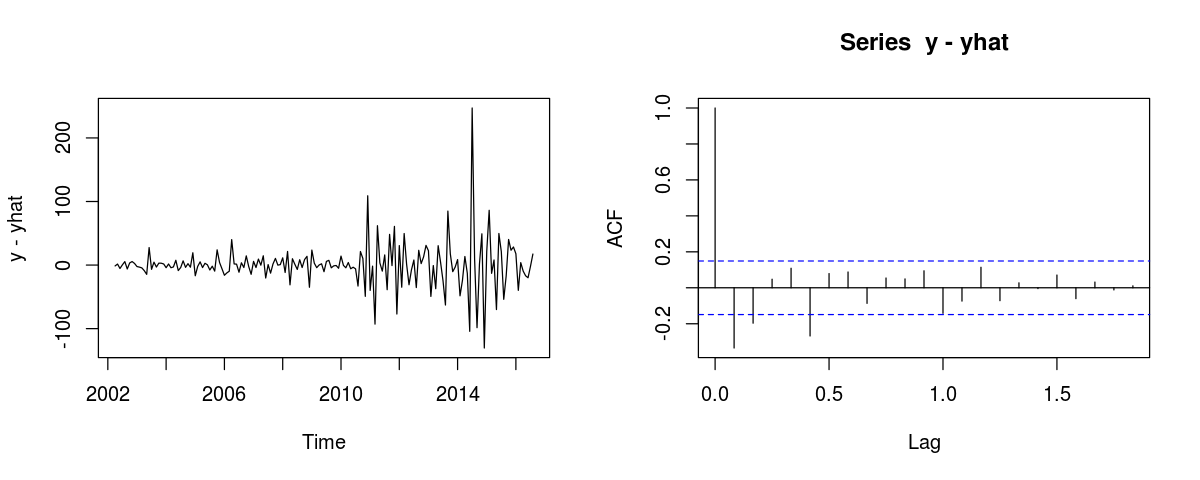

In [135]:
mu <- get_posterior_mean(fit1, par = 'mu')[, 'mean-all chains']
yhat <- ts(mu, start = start(y), frequency = frequency(y))

par(mfrow=c(1,2))
plot(y - yhat)
acf(y - yhat)

inference from above charts?

## Stochastic level plus slope
  $$log(y) \sim N(\mu[t], \sigma_{irreg})$$
  
  $$\mu[t] \sim N(\mu[t-1] + v[t-1], \sigma_{level})$$

  $$v[t] \sim N(v[t-1], \sigma_{slope})$$


In [5]:
# model_file2 <- '../../code/04-stan-models-02/model02.stan'
# fit2 <- invisible(stan(file = model_file1, data = standata,
#                             warmup = 10000, iter = 20000, chains = 1))
# save(file="code/04-stan-models-02/rda/fit2.rda",fit2)

In [4]:
load(file="rda/fit2.rda")
stopifnot(is.converged(fit2))

## Predicted and actual comparison

Don't know how to automatically pick scale for object of type yearmon. Defaulting to continuous.


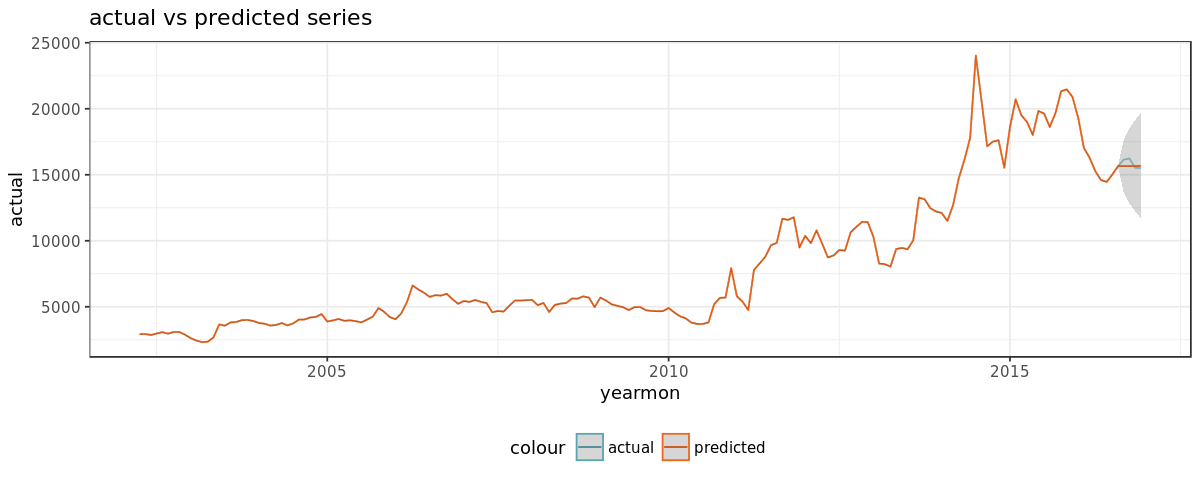

In [8]:
fit_ss2 <- extract(fit2 , permuted = TRUE)

plotPrediction <- function(trainvec,valvec,fitss){
    trainquants <- t(as.matrix(apply(fitss$yhat, 2, quantile, probs = c(.025, .5, .975))))
    valquants <- t(as.matrix(apply(fitss$ypred, 2, quantile, probs = c(.025, .5, .975))))
    plotdf <- data.frame(actual = c(trainvec,valvec),yearmon = c(as.yearmon(time(y)),as.yearmon(time(yval))))
    plotdf <- cbind(plotdf,rbind(trainquants,valquants))

    q <- ggplot(plotdf, aes(x = yearmon, y = actual, colour = "actual")) + 
                  geom_line(alpha=0.6) +
                  geom_line(aes(y=`50%`,colour="predicted",), data = plotdf) +
                  geom_ribbon(aes(ymax = `97.5%`, ymin = `2.5%`, colour = NULL), data = plotdf, alpha = 0.2) +
                  scale_color_manual(values=c("actual"="#58a4b0", "predicted"="#f26419")) +
                  theme(legend.position="bottom") +
                  ggtitle("actual vs predicted series")
    print(q)
}
plotPrediction(y,yval,fit_ss2)


Training data fit looks better now. But the prediction interval is still very wide

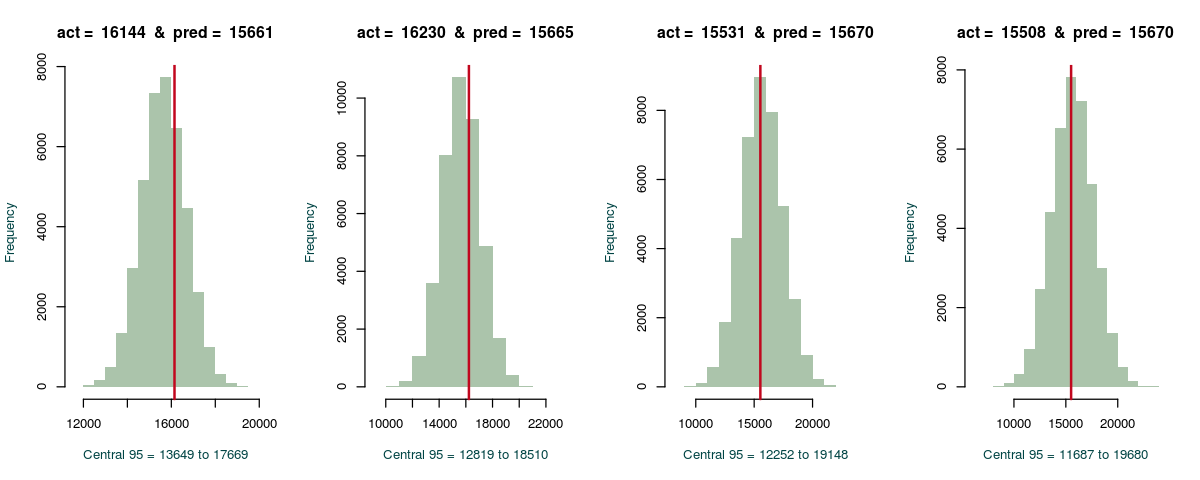

In [9]:
valpred <- as.data.frame(fit_ss2$ypred)
colnames(valpred) <- paste(as.yearmon(time(yval)))

valplots <- list()

par(mfrow=c(1,ncol(valpred)))
for (i in 1:ncol(valpred)){
    hist(valpred[,i],
         xlab = paste("Central 95 =",paste(round(quantile(valpred[,i],c(0.025,0.975))),collapse=" to ")),
         main= paste("act = ",round(yval[i])," & ","pred = ",round(mean(valpred[,i]))),col="#abc4ab",lty=0.2,
         col.lab = "#004444")
    abline(v=yval[i],col="#c1071e",lwd = 2)
}

## Posterior distributions

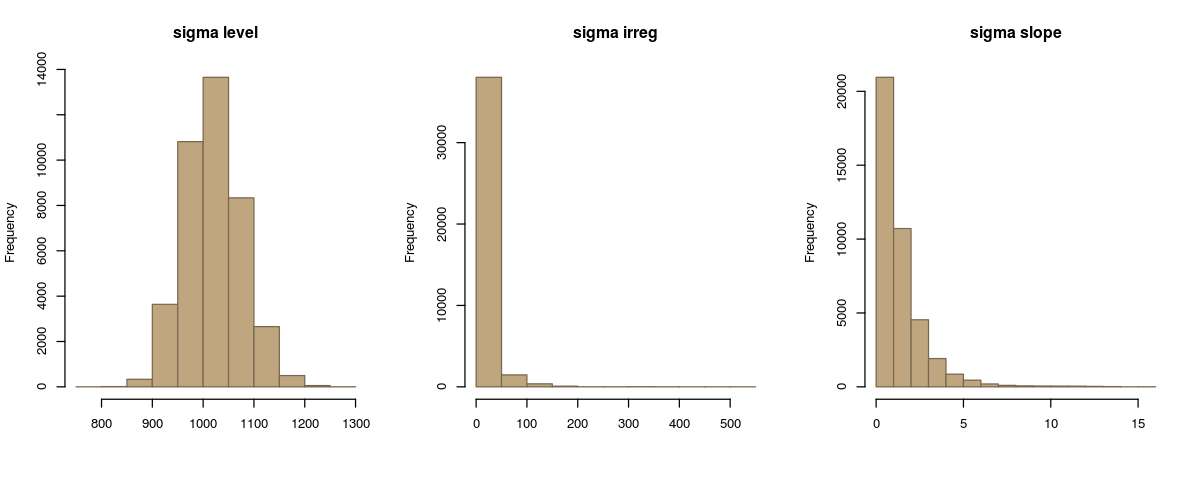

In [10]:
par(mfrow=c(1,3))
hist(fit_ss2$sigma[,3],main="sigma level",xlab = NULL,col="#bfa67e", border = "#77684f")
hist(fit_ss2$sigma[,2],main="sigma irreg",xlab = NULL,col="#bfa67e", border = "#77684f")
hist(fit_ss2$sigma[,1],main="sigma slope",xlab = NULL,col="#bfa67e", border = "#77684f")

Sigma irregular has now reduced in magnitude

## Residual plots

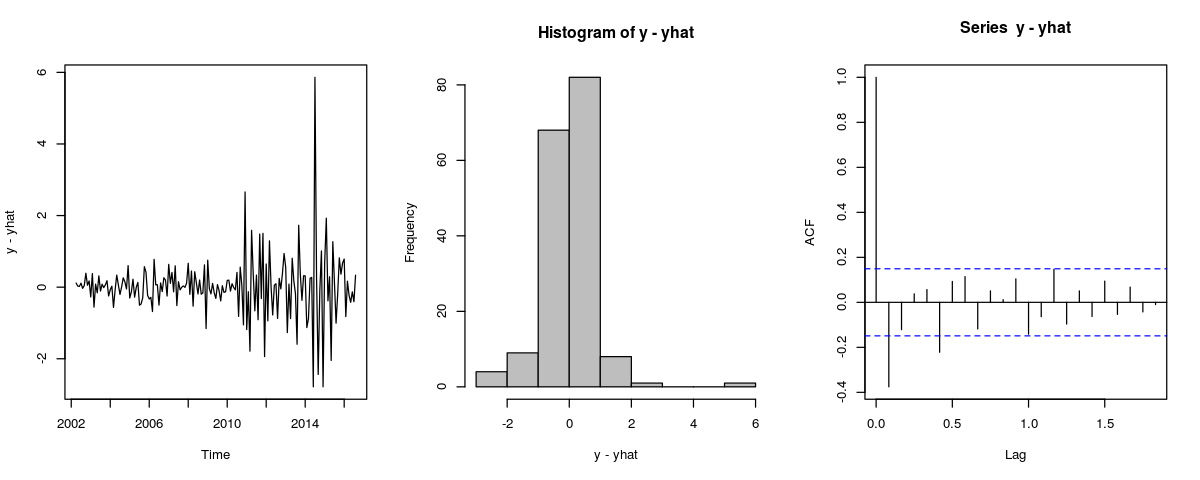

In [11]:
mu <- get_posterior_mean(fit2, par = 'mu')[, 'mean-all chains']
yhat <- ts(mu, start = start(y), frequency = frequency(y))

par(mfrow=c(1,3))
plot(y - yhat)
hist(y - yhat,col="grey")
acf(y - yhat)

The noise term has almost constant variance, also there is no residual auto-correlation